## Repeated-measures statistics for amod experiments
Nick Ponvert, 2019-03-18

In the amod experiments, we test animals using a behavioral paradigm where the type of auditory stimulus that must be discriminated varies from trial to trial. We have been using two types of auditory stimuli: chords of different frequencies, and amplitude-modulated noise with different modulation rates. The animal is required to discriminate low vs. high frequencies on trials where a chord is presented, and fast vs. slow modulation rates on trials where an AM sound is presented. We have been interleaving chord and AM trials so that the type of stimulus switches back and forth each trial. 

Animals performing this task are then administered intracranial injections of either saline or muscimol before each behavioral session. We alternate between saline and muscimol injections from one day to the next. So the experimental structure looks like this: 

* Multiple animals performing the task (we may be able to forget this for now and analyze each animal independently)
* Multiple tasks being performed by each animal each day (but performance on the two tasks **may be correlated**)
* Performance is evaluated over several days. 
* On each day, one of two manipulations is performed. 

A confound: 
* The starting accuracy on the two tasks is not the same. 

We are interested in: 
* Whether the muscimol affects task performance, and specifically whether it affects performance of one task more than the other.

## What type of test we are going to use
We want to have our model take into account that the performance starts at different levels. Then, we want to test whether allowing the effect of muscimol to differ between the two tasks explains more variance than modeling the effect of muscimol on the two tasks as the same. 

Statistically, we are going to use mixed-effect modeling to acheive this. We will include the sound type as a random effect, since we aren't interested in how the type of sound affected the subject's performance. Additionally, since outcomes are measured as number of successes vs. failures, we will have to do this as a logistic regression. So, we are looking at a generalized linear mixed-effect model. 

### Mixed models
**Note:** There are many more (and much better) explanations of mixed models and their applications out there. Check out some of the souces at the end of this section. 

In regression models, the goal is to estimate some parameter as a linear combination of predictor variables, multiplied by a set of regression coefficients. Mixed effect models break predictor variables into two classes: **fixed factors** and **random factors**. Fixed factors occur when you sample across the entire population you intend to study. For instance, if you are interested in comparing the battery life across 4 brands of batteries, then you sample from those 4 battery brands and use the brand as a fixed factor. In this case, the *population* is just the 4 brands of batteries that you are testing. However, if you are interested in learning something about the *larger population* of batteries as a whole, you can treat the brand as a **random effect**. In this case, any variation due to the different brands is not necessarily indicative of the entire population, beacuse you only have a small sample of 4 brands within that larger population. However, using this kind of model you can include data from the 4 different brands together in the same analysis, while accounting for the group-level variation that could occur between the different brands. A grouping variable can be modeled as a random effect if you aren't interested in evaluating its effect on the dependent variable directly, but want to take into account the covariance that will occur between samples in a group. These kinds of models are often used in biology because data are often collected in a way that leads to groupings: 

* An ecologist samples barnacles across 5 sites, counting 5 areas at each site. Data are grouped by site (site is a random factor).
* A medical study performs tests on subjects many times over a period of years. In this type of experiment (repeated measures), data are grouped by individual (individual # is a random factor).

#### Random intercepts vs. random slopes
Within a mixed effect model, there are two ways that you can specify a random effect. The random effect may only change the intercept for each group by some amount, while leaving the slope (coefficient value) for each regression term the same between all groups. Alternatively, the model can allow both the intercept and the slope of the regression to vary between the groups. 

### The test we will perform
We are interested in whether the effect of muscimol varies across a grouping variable, the sound type. The effect of muscimol is what we are interested in, so that will be a fixed factor. We aren't really interested in whether the type of sound affects the performance on the task, but observations collected from within each sound type group will be correlated with each other. So, we will treat sound type as a random factor. The question we will test is whether it is better to use a *random intercept* model or a *random slope* model to explain the additional variance due to the different sound types. If a random intercept model is sufficient, then we will accept the null hypothesis that there is no difference in the size of the effect (slope, or coefficient value) of muscimol between the different sound types. However, if a random slope model has a significantly better goodness-of-fit, then we will reject the null hypothesis. 


**The plan:**
Compare a model with random slopes (allowing the muscimol to have a different effect on chord performance and tone performance) to a model with just random intercepts (allowing chord and tone performance to start at a different level, but assuming the same effect of muscimol on each). If the random slope model explains significantly more variance than the random intercepts model, then we can conclude that the effect of muscimol is different on the two sound types. 

### Resources
I relied on the following resources when learning about mixed models and working on this analysis:
* https://www.kaggle.com/ojwatson/mixed-models
* https://www.r-bloggers.com/random-regression-coefficients-using-lme4/
* https://stats.stackexchange.com/questions/89521/binomial-count-data-use-glmer-lmer-or-just-average-it-all?rq=1
* https://stats.stackexchange.com/questions/6505/likelihood-ratio-test-in-r
* https://bookdown.org/ndphillips/YaRrr/comparing-regression-models-with-anova.html
* https://stats.stackexchange.com/questions/96600/interactions-between-random-effects
* http://www.bristol.ac.uk/media-library/sites/cmm/migrated/documents/random-slopes.pdf

In [5]:
# First we import required packages
import os
import numpy as np
from matplotlib import pyplot as plt
from jaratoolbox import behavioranalysis
from jaratoolbox import extraplots
from jaratest.nick.behavior import soundtypes

### Using R inside Python to fit statistical models
While the python package `statsmodels` provides support for linear mixed-effect models and generalized linear models via a simple `function` api, the available Python implemenations of generalized linear mixed-effect models are pretty confusing (see: https://www.statsmodels.org/stable/mixed_glm.html). I don't have time to get into the weeds learning how to implement the models in Python, so I am going to use R to do it. The implementation in R is straightforward and uses the familiar function syntax. We will use the rpy2 module to run R code from our Python kernel (https://rpy2.readthedocs.io/en/version_2.8.x/)

In [3]:
# We will use rpy2 to run R code
import rpy2
print rpy2.__version__

2.8.6


### Load data files and calculate correct and incorrect trials
The first step is to load the data that was collected on each experimental day and calculate the animal's performance during each beahvioral session. We also have to split the trials of each session according to the type of sound that was presented. 

In [117]:
# The subject to analyze (doing a single subject at a time for now)
animals = ['amod003']
# Experimental sessions collected for this subject
sessions = ['20160412a', '20160413a', '20160414a', '20160415a', '20160416a',
               '20160417a', '20160418a', '20160419a', '20160420a', '20160421a']
# Whether or not muscimol was injected (0: saline, 1: muscimol)
muscimol = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Initialize empty lists to save results of iterating through the sessions
allnCorr = [] #Number of correct trials
allnVal = [] #Number of valid trials
allfracCorr = [] #Fraction correct trials
sessionInd = [] #Index in the list of sessions (to track time)
animalInd = [] #Index in the list of animals (in case we do more than 1 animal at a time)
soundType = [] #Type of sound that was presented (0: AM, 1: chords)
muscimolInjected = [] #Muscimol or saline

# Iterate through animals and behavior sessions
for indAnimal, animal in enumerate(animals):
    for indSession, session in enumerate(sessions):
        # Load the data for this session, this animal, and split by the sound type presented
        (bdataObjs, bdataSoundTypes) = soundtypes.load_behavior_sessions_sound_type(animal, [session])
        # Iterate through the different sound types
        for st in [0, 1]: #0 = mod, 1=chord
            # Choose the bdata object corresponding to this sound type
            bdata = bdataObjs[st]
            # Calculate number of correct and valid trials
            nCorr = sum(bdata['outcome']==bdata.labels['outcome']['correct'])
            nVal = sum(bdata['valid'])
            # Append values to appropriate lists
            allfracCorr.append(nCorr.astype(float)/nVal)
            allnCorr.append(nCorr)
            allnVal.append(nVal)
            sessionInd.append(indSession)
            animalInd.append(indAnimal)
            soundType.append(st)
            muscimolInjected.append(muscimol[indSession])

# Convert the lists to numpy arrays.
allnCorr = np.array(allnCorr)
allnVal = np.array(allnVal)
allfracCorr = np.array(allfracCorr)
sessionInd = np.array(sessionInd)
animalInd = np.array(animalInd)
soundType = np.array(soundType)
muscimolInjected = np.array(muscimolInjected)

### Chord performance is better than AM performance
The performance for the frequency discrimination is better, but this isn't really an effect we are interested in.

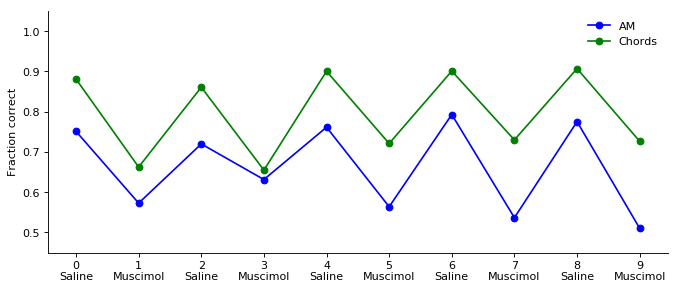

In [28]:
# Make the figure wider
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')

# Plot the percentage of correct responses across sessions
plt.plot(sessionInd[soundType==0], allfracCorr[soundType==0], 'b-o', label='AM')
plt.plot(sessionInd[soundType==1], allfracCorr[soundType==1], 'g-o', label='Chords')

plt.legend(frameon=False)
ax = plt.gca()
extraplots.boxoff(ax)
ax.set_ylabel('Fraction correct')
ax.set_ylim([.45, 1.05])
ax.set_xticks(range(np.max(sessionInd)+1))
# Note: If you cath the text that is returned, it won't print (which is good)
_ = ax.set_xticklabels(['{}\n{}'.format(ind, ['Saline', 'Muscimol'][mus]) for ind, mus in enumerate(muscimolInjected[soundType==1])])

### Fit a simple linear model in R

In [40]:
# First we import rpy2, which starts an R process, and then load the libraries we need

from rpy2.robjects.packages import importr
base=importr('base')
utils=importr('utils')

# I had to run this code first to install the lme4 package
#utils.chooseCRANmirror(ind=1) # use the first CRAN mirror to install packages
#utils.install_packages('lme4')

# After install, just use this to import lme4, the library that implements the model we want to use.
lme4=importr('lme4')

In [86]:
# Cast our np arrays as FloatVectors to pass to R
from rpy2 import robjects

# Need the number of incorrect trials
allnIncorr = allnVal - allnCorr

# Just a sanity check here
assert np.all(allnCorr + allnIncorr == allnVal)

allnCorrR = robjects.FloatVector(allnCorr)
allnIncorrR = robjects.FloatVector(allnIncorr)
allnValR = robjects.FloatVector(allnVal)
sessionIndR = robjects.FloatVector(sessionInd)
animalIndR = robjects.FloatVector(animalInd)
soundTypeR = robjects.FloatVector(soundType)
muscimolInjectedR = robjects.FloatVector(muscimolInjected)

# Inject these variables into the R global environment. Gross! But we do what we must. 
# Update: There are other ways to do things like this - you can define Environments
robjects.globalenv["nCorr"] = allnCorrR
robjects.globalenv["nIncorr"] = allnIncorrR
robjects.globalenv["nVal"] = allnValR
robjects.globalenv["session"] = sessionIndR
robjects.globalenv["animal"] = animalIndR
robjects.globalenv["soundtype"] = soundTypeR
robjects.globalenv["muscimol"] = muscimolInjectedR

### The Pythonic, but less convenient, way to interact with R code
`rpy2` allows us to import everything into the Python environment, and then interact with it in a Pythonic way. We can fit the first, random-intercept-only model using this syntax. However, the process of getting information about the model seems somewhat difficult. 

In [63]:
# Fit the model
interceptModel = lme4.glmer('cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype)', family = 'binomial')

In [64]:
# If we fit the model this way, the summary is not helpful. 
base.summary(interceptModel)

R object with classes: ('summary.merMod',) mapped to:
<ListVector - Python:0x7fa55841a878 / R:0x556b523e8b30>
[StrVe..., StrVe..., ListV..., ..., Float..., StrVe..., ListV...]
  methTitle: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7fa570838cb0 / R:0x556b510322f8>
[str]
  objClass: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7fa5583a3fc8 / R:0x556b57b8c308>
[str]
R object with classes: ('summary.merMod',) mapped to:
<ListVector - Python:0x7fa55841a878 / R:0x556b523e8b30>
[StrVe..., StrVe..., ListV..., ..., Float..., StrVe..., ListV...]
  ...
  methTitle: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fa5583a3f38 / R:0x556b53a8d830>
[-1.340059, 0.346716, 0.956172, ..., 2.102353, -1.802950, 0.701507]
  objClass: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes:

### Converting to R cells on the fly
There is an extension called `rpy2.ipython` which is truly cool, becuase it allows us to turn individual cells into R cells. I like this because I almost always want to do all the data loading, processing, and plotting in Python, and only use R for some statistical models like here. 

In [67]:
# There appears to be another way to interact with the R environment, which is awesome
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [85]:
%%R #Just add this line here...

# ...and we have access to the variables we pushed earlier
nCorr

 [1] 335 392 279 322 311 371 341 353 383 452 322 411 425 482 241 327 376 439 245
[20] 348


### Fit the intercept-only model
First we are going to model the data using only a random intercept. That is, we allow the intercept, or the starting point for performance, to differ between the two sound type conditions (which we know is true just from plotting the data above). In this model, the slope of the muscimol effect is kept the same between the two conditions. 

In [78]:
%%R
interceptModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype), family = binomial)
summary(interceptModel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype)

     AIC      BIC   logLik deviance df.resid 
   200.8    203.7    -97.4    194.8       17 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9266 -1.0274  0.4120  0.8819  3.7442 

Random effects:
 Groups    Name        Variance Std.Dev.
 soundtype (Intercept) 0.1233   0.3512  
Number of obs: 20, groups:  soundtype, 2

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.60096    0.25135   6.369  1.9e-10 ***
muscimol    -1.04512    0.04861 -21.499  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
muscimol -0.122


### Fit the random-slope model
Now, we model the data in a way that allows the slope of the muscimol effect to differ between the sound type conditions. If this model explains significantly more variance than the intercept-only model, we will argue that the effect of muscimol on discrimination performance for the different sound types.

In [82]:
%%R
slopeModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype), family = binomial)
summary(slopeModel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype)

     AIC      BIC   logLik deviance df.resid 
   191.7    196.7    -90.9    181.7       15 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4401 -1.3470  0.1361  1.1716  3.0876 

Random effects:
 Groups    Name        Variance Std.Dev. Corr 
 soundtype (Intercept) 0.21877  0.4677        
           muscimol    0.03251  0.1803   -1.00
Number of obs: 20, groups:  soundtype, 2

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.6319     0.3332   4.898 9.70e-07 ***
muscimol     -1.0816     0.1370  -7.893 2.94e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
muscimol -0.960
convergence code: 0
boundary (singular) fit: see ?isSingular



### Compare the two models with ANOVA
The R function `anova` can be used to compare the goodness-of-fit of two models. 

In [79]:
%%R
anova(slopeModel, interceptModel)

Data: NULL
Models:
interceptModel: cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype)
slopeModel: cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype)
               Df    AIC    BIC  logLik deviance Chisq Chi Df Pr(>Chisq)   
interceptModel  3 200.76 203.74 -97.379   194.76                           
slopeModel      5 191.73 196.71 -90.864   181.73 13.03      2   0.001481 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The `anova` test shows that the goodness of fit is significantly different between the two models. In this case, **we reject the null hypothesis that the effect of muscimol is the same between the different sound types for this animal**.

## Perform the same test with a different animal
We performed the test with the animal `amod003`. Let's test and see if we get the same result with `amod002`

In [118]:
# The subject to analyze (doing a single subject at a time for now)
animals = ['amod002']
# Experimental sessions collected for this subject
sessions = ['20160412a', '20160413a', '20160414a', '20160415a', '20160416a',
               '20160417a', '20160418a', '20160419a', '20160420a', '20160421a']
# Whether or not muscimol was injected (0: saline, 1: muscimol)
muscimol = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Initialize empty lists to save results of iterating through the sessions
allnCorr = [] #Number of correct trials
allnVal = [] #Number of valid trials
allfracCorr = [] #Fraction correct trials
sessionInd = [] #Index in the list of sessions (to track time)
animalInd = [] #Index in the list of animals (in case we do more than 1 animal at a time)
soundType = [] #Type of sound that was presented (0: AM, 1: chords)
muscimolInjected = [] #Muscimol or saline

# Iterate through animals and behavior sessions
for indAnimal, animal in enumerate(animals):
    for indSession, session in enumerate(sessions):
        # Load the data for this session, this animal, and split by the sound type presented
        (bdataObjs, bdataSoundTypes) = soundtypes.load_behavior_sessions_sound_type(animal, [session])
        # Iterate through the different sound types
        for st in [0, 1]: #0 = mod, 1=chord
            # Choose the bdata object corresponding to this sound type
            bdata = bdataObjs[st]
            # Calculate number of correct and valid trials
            nCorr = sum(bdata['outcome']==bdata.labels['outcome']['correct'])
            nVal = sum(bdata['valid'])
            # Append values to appropriate lists
            allfracCorr.append(nCorr.astype(float)/nVal)
            allnCorr.append(nCorr)
            allnVal.append(nVal)
            sessionInd.append(indSession)
            animalInd.append(indAnimal)
            soundType.append(st)
            muscimolInjected.append(muscimol[indSession])

# Convert the lists to numpy arrays.
allnCorr = np.array(allnCorr)
allnVal = np.array(allnVal)
allfracCorr = np.array(allfracCorr)
sessionInd = np.array(sessionInd)
animalInd = np.array(animalInd)
soundType = np.array(soundType)
muscimolInjected = np.array(muscimolInjected)

In [88]:
# Cast our np arrays as FloatVectors to pass to R
from rpy2 import robjects

# Need the number of incorrect trials
allnIncorr = allnVal - allnCorr

# Just a sanity check here
assert np.all(allnCorr + allnIncorr == allnVal)

allnCorrR = robjects.FloatVector(allnCorr)
allnIncorrR = robjects.FloatVector(allnIncorr)
allnValR = robjects.FloatVector(allnVal)
sessionIndR = robjects.FloatVector(sessionInd)
animalIndR = robjects.FloatVector(animalInd)
soundTypeR = robjects.FloatVector(soundType)
muscimolInjectedR = robjects.FloatVector(muscimolInjected)

# Inject these variables into the R global environment. Gross! But we do what we must. 
# Update: There are other ways to do things like this - you can define Environments
robjects.globalenv["nCorr"] = allnCorrR
robjects.globalenv["nIncorr"] = allnIncorrR
robjects.globalenv["nVal"] = allnValR
robjects.globalenv["session"] = sessionIndR
robjects.globalenv["animal"] = animalIndR
robjects.globalenv["soundtype"] = soundTypeR
robjects.globalenv["muscimol"] = muscimolInjectedR

In [119]:
%%R
nCorr

 [1] 404 420 306 377 433 480 294 429 430 492 329 394 453 491 276 403 382 427 282
[20] 363 335 392 279 322 311 371 341 353 383 452 322 411 425 482 241 327 376 439
[39] 245 348


In [115]:
%%R
interceptModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype), family = binomial)
slopeModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype), family = binomial)
anova(slopeModel, interceptModel)

Data: NULL
Models:
interceptModel: cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype)
slopeModel: cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype)
               Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
interceptModel  3 375.95 381.02 -184.97   369.95                         
slopeModel      5 378.36 386.80 -184.18   368.36 1.5891      2     0.4518


For the animal `amod002`, switching to the random slopes model does not significantly improve the fit, and therefore we don'r reject the null hypothesis that the value of the muscimol coefficient is the same between the two sound types.

## Modeling data from multiple animals
One of the strengths of mixed-effect modeling for neuroscience is that it allows data from multiple animals to be included together without first averaging whatever you are interested across each animal. Since data are grouped by animal, but the animal-to-animal differences aren't meaningful for this analysis, you include the animalID as an additional random effect. 

In [93]:
# The subject to analyze (doing a single subject at a time for now)
animals = ['amod002', 'amod003']
# Experimental sessions collected for this subject
sessions = {'amod002':['20160412a', '20160413a', '20160414a', '20160415a', '20160416a',
            '20160417a', '20160418a', '20160419a', '20160420a', '20160421a'],
            'amod003':['20160412a', '20160413a', '20160414a', '20160415a', '20160416a',
            '20160417a', '20160418a', '20160419a', '20160420a', '20160421a'],
            'amod004;'
# Whether or not muscimol was injected (0: saline, 1: muscimol)
muscimol = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Initialize empty lists to save results of iterating through the sessions
allnCorr = [] #Number of correct trials
allnVal = [] #Number of valid trials
allfracCorr = [] #Fraction correct trials
sessionInd = [] #Index in the list of sessions (to track time)
animalInd = [] #Index in the list of animals (in case we do more than 1 animal at a time)
soundType = [] #Type of sound that was presented (0: AM, 1: chords)
muscimolInjected = [] #Muscimol or saline

# Iterate through animals and behavior sessions
for indAnimal, animal in enumerate(animals):
    for indSession, session in enumerate(sessions):
        # Load the data for this session, this animal, and split by the sound type presented
        (bdataObjs, bdataSoundTypes) = soundtypes.load_behavior_sessions_sound_type(animal, [session])
        # Iterate through the different sound types
        for st in [0, 1]: #0 = mod, 1=chord
            # Choose the bdata object corresponding to this sound type
            bdata = bdataObjs[st]
            # Calculate number of correct and valid trials
            nCorr = sum(bdata['outcome']==bdata.labels['outcome']['correct'])
            nVal = sum(bdata['valid'])
            # Append values to appropriate lists
            allfracCorr.append(nCorr.astype(float)/nVal)
            allnCorr.append(nCorr)
            allnVal.append(nVal)
            sessionInd.append(indSession)
            animalInd.append(indAnimal)
            soundType.append(st)
            muscimolInjected.append(muscimol[indSession])

# Convert the lists to numpy arrays.
allnCorr = np.array(allnCorr)
allnVal = np.array(allnVal)
allfracCorr = np.array(allfracCorr)
sessionInd = np.array(sessionInd)
animalInd = np.array(animalInd)
soundType = np.array(soundType)
muscimolInjected = np.array(muscimolInjected)

In [94]:
# Cast our np arrays as FloatVectors to pass to R
from rpy2 import robjects

# Need the number of incorrect trials
allnIncorr = allnVal - allnCorr

# Just a sanity check here
assert np.all(allnCorr + allnIncorr == allnVal)

allnCorrR = robjects.FloatVector(allnCorr)
allnIncorrR = robjects.FloatVector(allnIncorr)
allnValR = robjects.FloatVector(allnVal)
sessionIndR = robjects.FloatVector(sessionInd)
animalIndR = robjects.FloatVector(animalInd)
soundTypeR = robjects.FloatVector(soundType)
muscimolInjectedR = robjects.FloatVector(muscimolInjected)

# Inject these variables into the R global environment. Gross! But we do what we must. 
# Update: There are other ways to do things like this - you can define Environments
robjects.globalenv["nCorr"] = allnCorrR
robjects.globalenv["nIncorr"] = allnIncorrR
robjects.globalenv["nVal"] = allnValR
robjects.globalenv["session"] = sessionIndR
robjects.globalenv["animal"] = animalIndR
robjects.globalenv["soundtype"] = soundTypeR
robjects.globalenv["muscimol"] = muscimolInjectedR

In [95]:
%%R
nCorr

 [1] 404 420 306 377 433 480 294 429 430 492 329 394 453 491 276 403 382 427 282
[20] 363 335 392 279 322 311 371 341 353 383 452 322 411 425 482 241 327 376 439
[39] 245 348


In [99]:
%%R
interceptModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype) + (1 | animal), family = binomial)
summary(interceptModel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype) + (1 | animal)

     AIC      BIC   logLik deviance df.resid 
   377.7    384.4   -184.8    369.7       36 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2089 -1.2070  0.1309  1.0347  3.8077 

Random effects:
 Groups    Name        Variance  Std.Dev.
 soundtype (Intercept) 0.1253504 0.35405 
 animal    (Intercept) 0.0004853 0.02203 
Number of obs: 40, groups:  soundtype, 2; animal, 2

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.6500     0.2523   6.539 6.18e-11 ***
muscimol     -1.0856     0.0340 -31.933  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
muscimol -0.086


In [116]:
%%R
slopeModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype) + (1 | animal), family = binomial)
summary(slopeModel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype) +  
    (1 | animal)

     AIC      BIC   logLik deviance df.resid 
   380.1    390.2   -184.0    368.1       34 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0087 -1.2625  0.1258  1.0032  3.6479 

Random effects:
 Groups    Name        Variance  Std.Dev. Corr 
 soundtype (Intercept) 0.1461025 0.38223       
           muscimol    0.0019075 0.04367  -1.00
 animal    (Intercept) 0.0004782 0.02187       
Number of obs: 40, groups:  soundtype, 2; animal, 2

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.65687    0.27216   6.088 1.14e-09 ***
muscimol    -1.09396    0.04646 -23.546  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
muscimol -0.722
convergence code: 0
boun

In [110]:
%%R
anova(interceptModel, slopeModel)

Data: NULL
Models:
interceptModel: cbind(nCorr, nIncorr) ~ muscimol + (1 | soundtype) + (1 | animal)
slopeModel: cbind(nCorr, nIncorr) ~ muscimol + (1 + muscimol | soundtype) + 
slopeModel:     (1 | animal:soundtype)
               Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
interceptModel  4 377.68 384.44 -184.84   369.68                         
slopeModel      6 380.36 390.49 -184.18   368.36 1.3246      2     0.5157


So, when we look at all the data together it appears that attempting to model different muscimol effects for each sound type does not significantly increase the goodness-of-fit of the model. 

### A model with a fixed effect for soundtype
Let's try doing a model with a fixed effect for soundtype. We can then look at interactions between soundtype and muscimol in the more traditional linear model way. We still need to include the random effect related to the different animal groups. Also, it makes sense here to allow the coefficient for the effect of soundtype to vary between animals as well (as a random slope). 

In [114]:
%%R
fixedModel <- glmer(cbind(nCorr, nIncorr) ~ muscimol * soundtype + (1 + soundtype | animal), family = binomial)
summary(fixedModel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(nCorr, nIncorr) ~ muscimol * soundtype + (1 + soundtype |  
    animal)

     AIC      BIC   logLik deviance df.resid 
   369.5    381.3   -177.7    355.5       33 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1010 -1.1587  0.2452  0.9198  3.5361 

Random effects:
 Groups Name        Variance  Std.Dev.  Corr
 animal (Intercept) 0.000e+00 0.000e+00     
        soundtype   1.182e-18 1.087e-09  NaN
Number of obs: 40, groups:  animal, 2

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         1.27475    0.03412  37.360   <2e-16 ***
muscimol           -1.05032    0.04401 -23.867   <2e-16 ***
soundtype           0.76544    0.05585  13.705   <2e-16 ***
muscimol:soundtype -0.08770    0.06944  -1.263    0.207    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed 

If we model soundtype as a fixed effect, we see that both the muscimol and the soundtype terms are significant, but that the interaction term is not. This is consistent with the results of our model comparisons above, in that it does not allow us to reject the null hypothesis that the effect of muscimol does not differ between sound types. 

# Conclusion
In a single animal, `amod003`, we found that the effect of muscimol inactivation on the ratio of correct to incorrect trials varied between the two sound types, with the muscimol coefficient estimate being slightly less negative for the Chords than for the AM sounds. However, a separate analysis of subject `amod002` did not lead us to reject the null hypothesis that the effect of muscimol is the same between both sound types. When we combined the data from these two animals into a single model (a strength of the generalized linear mixed-effect model) we similarly found that we could not reject the null hypothesis that the effect of muscimol is consistent across sound types. 

As a small and easily acheivable future direction, I should add in data from more animals.